# Matrix factorisation application

We begin by loading our helper script before applying the algorithm

In [90]:
import os, sys
%load_ext autoreload
%autoreload 2

src = '/Users/richardlastrucci/Library/Mobile Documents/com~apple~CloudDocs/University/Honours/Semester 2/COS 781/project/src'
sys.path.append(src)
import helper as h

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import pandas as pd 
import matplotlib.pyplot as plt

path = '/Users/richardlastrucci/Library/Mobile Documents/com~apple~CloudDocs/University/Honours/Semester 2/COS 781/project/data/application'

In [51]:
utility_matrix = pd.read_csv(f'{path}/train.csv')
utility_matrix.shape

(1700, 44)

### Define matrix factorisation algorithm

In [63]:
import numpy as np
import pandas as pd
from tqdm import tqdm  #

def matrix_factorization(utility_matrix, K=2, num_epochs=10000, lr=0.05, convergence_threshold=1e-5):
    R = utility_matrix.values if isinstance(utility_matrix, pd.DataFrame) else utility_matrix
    num_users, num_items = R.shape
    mask = (R > 0)
    n_mask = mask.sum()
    U = np.random.uniform(-1, 1, size=(num_users, K))
    V = np.random.uniform(-1, 1, size=(num_items, K))
    epoch_rmse_list = []
    
    prev_rmse = float('inf')
    
    for curr_epoch in tqdm(range(num_epochs), desc="Epochs", ncols=100):
        R_hat = U @ V.T
        error = (R - R_hat) * mask
        rmse = np.sqrt(np.sum(np.square(error[mask])) / n_mask)
        
        epoch_rmse_list.append([curr_epoch + 1, rmse, K, lr])
        
        if abs(prev_rmse - rmse) < convergence_threshold:
            print(f"Converged at epoch {curr_epoch + 1}.")
            break
        
        prev_rmse = rmse
        
        U_grad = -2.0 * (error @ V) / n_mask
        V_grad = -2.0 * (error.T @ U) / n_mask
        U -= lr * U_grad
        V -= lr * V_grad
    
    filled_matrix = pd.DataFrame(U @ V.T)
    epoch_rmse_df = pd.DataFrame(epoch_rmse_list, columns=["epoch", "rmse", "K", "lr"])
    return filled_matrix, epoch_rmse_df


### Compute different values of K 

In [88]:
_, epoch_rmse_df_3 = matrix_factorization(utility_matrix, K=3, convergence_threshold=1e-10)
_, epoch_rmse_df_5 = matrix_factorization(utility_matrix, K=5, convergence_threshold=1e-10)
_, epoch_rmse_df_7 = matrix_factorization(utility_matrix, K=7, convergence_threshold=1e-10)



Epochs:   0%|                                                             | 0/10000 [00:00<?, ?it/s]

Epochs: 100%|███████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1382.99it/s]


### plot values of K

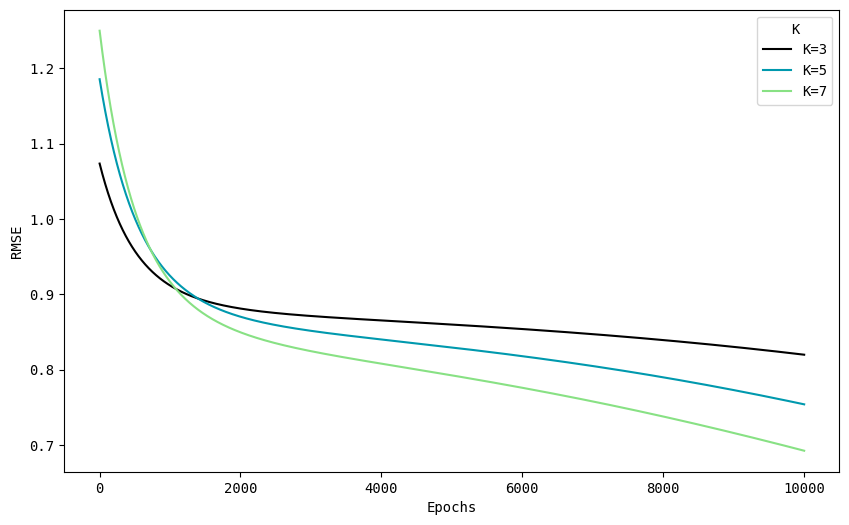

In [89]:
import matplotlib.pyplot as plt

combined_df = pd.concat([
    epoch_rmse_df_3,
    epoch_rmse_df_5,
    epoch_rmse_df_7
], ignore_index=True)


color_map = {
    2: h.deep,   
    5: h.sea,    
    7: h.green,  
}

plt.figure(figsize=(10, 6))

for K_value in combined_df['K'].unique():
    subset = combined_df[combined_df['K'] == K_value]
    plt.plot(subset['epoch'], subset['rmse'], label=f'K={K_value}', color=color_map.get(K_value, 'black'))  # default color is black if K_value is not in color_map
    
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend(title="K")
plt.show()


### predict matrix 

In [80]:
filled_matrix, _ = matrix_factorization(utility_matrix, lr=0.2, K=3, num_epochs=25000)

Epochs:  59%|███████████████████████████▋                   | 14747/25000 [00:08<00:05, 1766.96it/s]

Converged at epoch 14748.


### plot predicted matrix

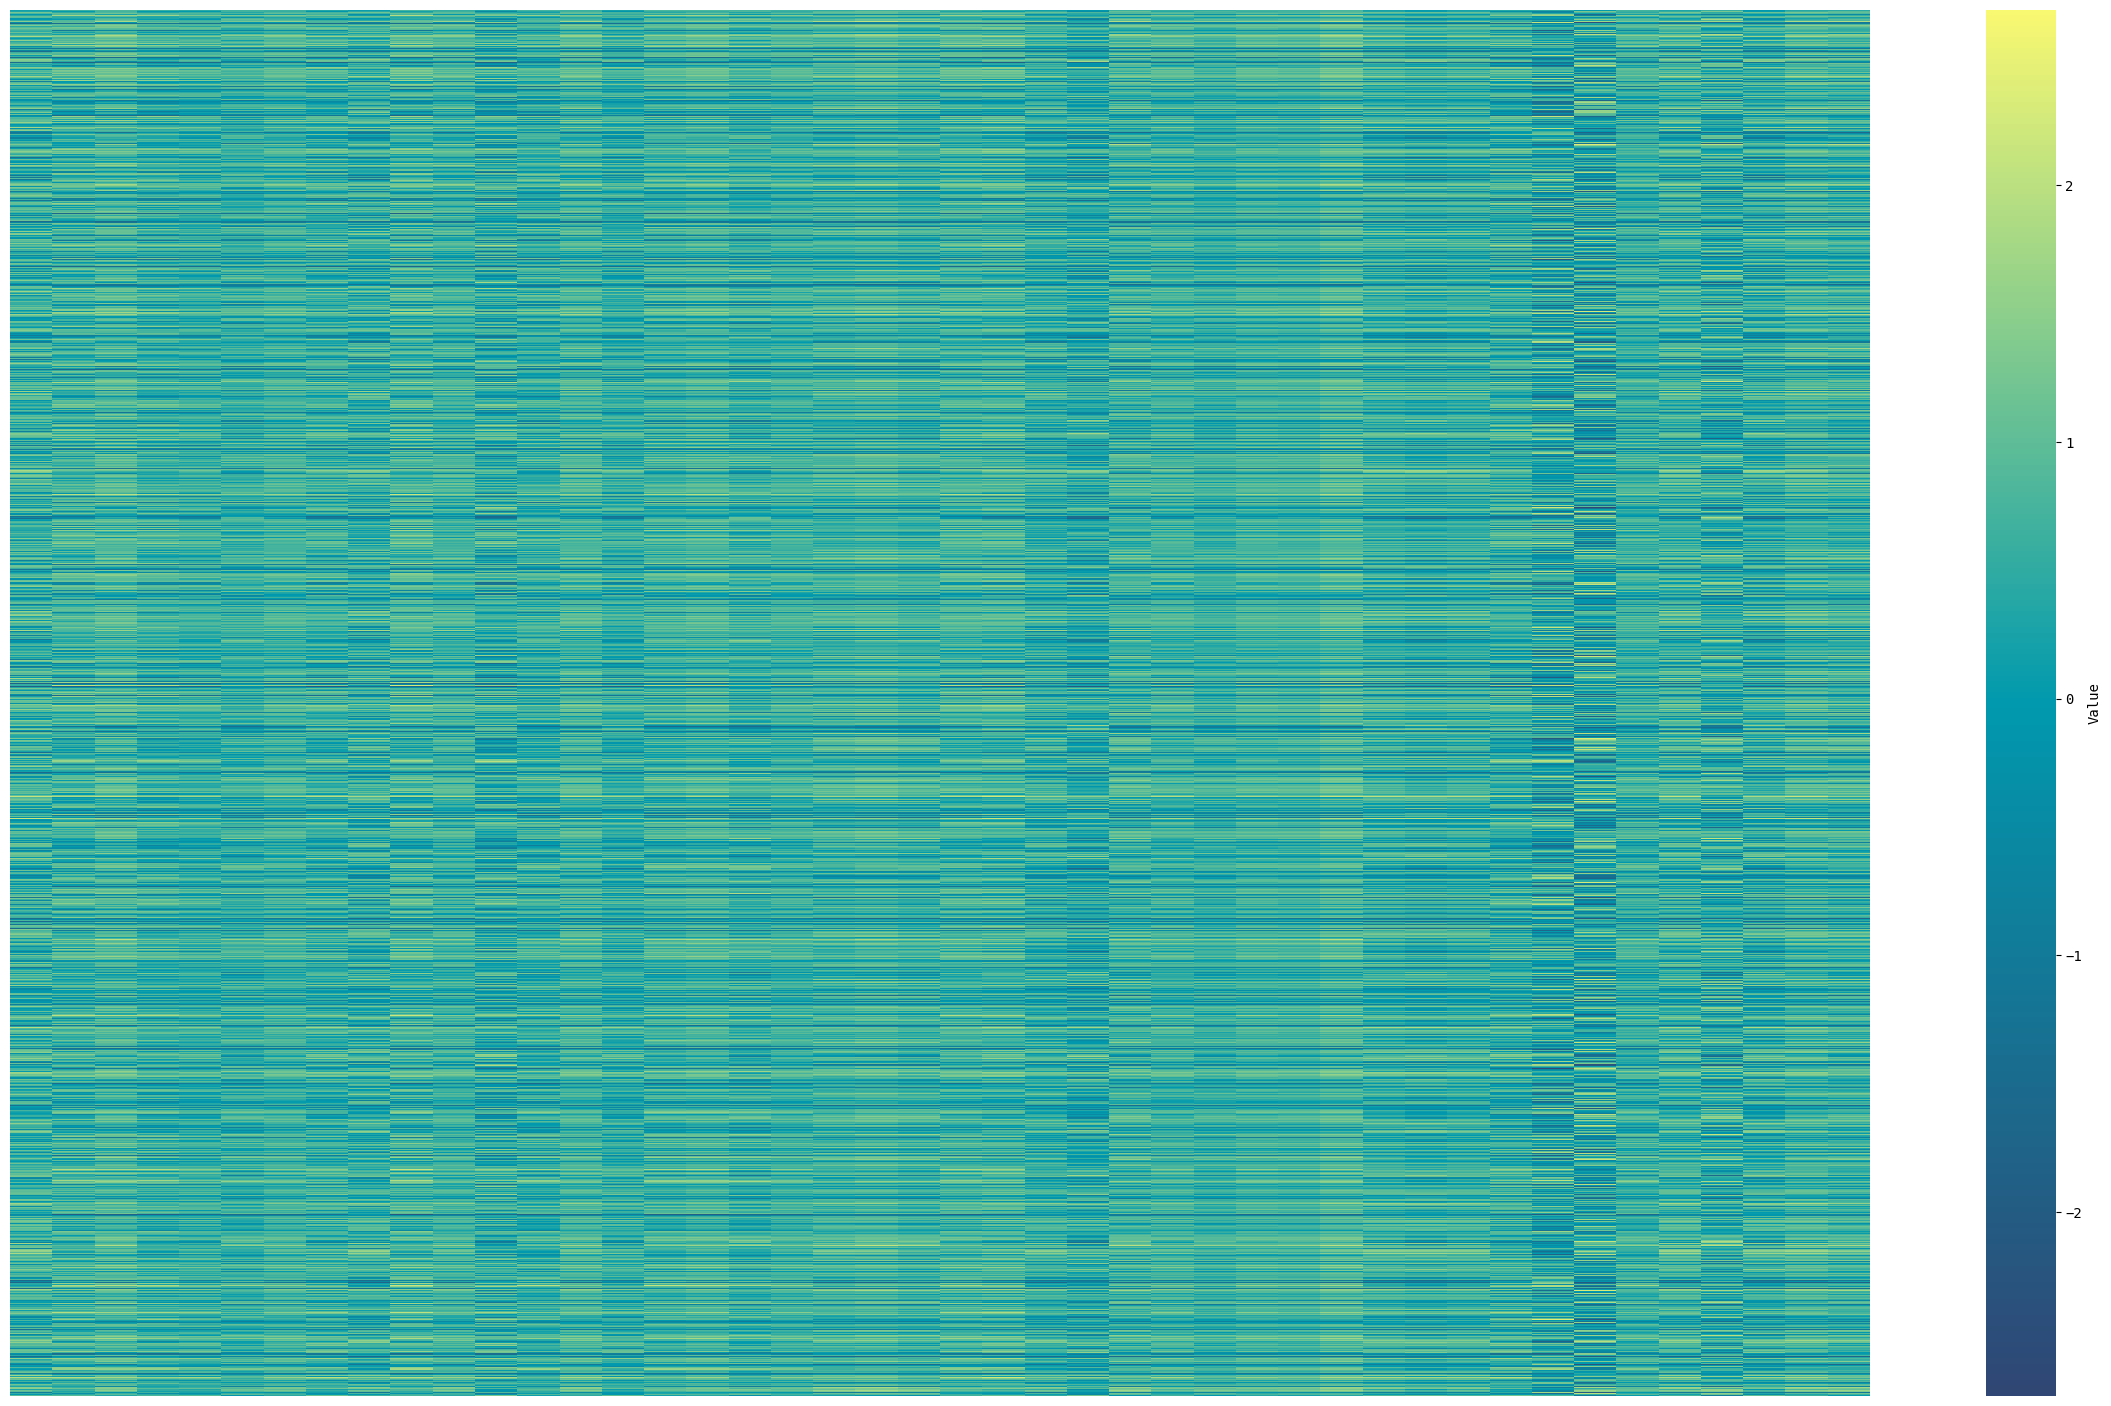

In [81]:
h.plot_large_heatmap(filled_matrix)

In [82]:
test = pd.read_csv(f'{path}/test.csv')
test.shape

(732, 3)

### compute RMSE

In [83]:
import numpy as np
squared_error_sum = 0
n = len(test)


for _, row in test.iterrows():
    r, c, v = int(row['r']), int(row['c']), row['v']
    
    predicted_value = filled_matrix.iloc[r, c]
    squared_error_sum += (v - predicted_value) ** 2
rmse = np.sqrt(squared_error_sum / n)
rmse

np.float64(0.7923664323715578)